In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import surtseygeotherm as sgt

In [2]:
import asdf

In [3]:
sgt.info.terse

The Surtsey-Geotherm Package
----------------------------
Version: 0.8.3

  - Start time: 2018-06-13 11:24:44
  - End time: 2019-10-17 14:04:36

Recorded Data Columns
  - Mass (in kg).
  - T0 ... T15: tempertatures (in °C).
  - 'CJC03', 'CJC47', 'CJC811', 'CJC1215': Cold junction compensation readings (in °C).

In [4]:
trecs = sgt.records_from_timespan('2018-06-01', '2019-11-01', 'df')
trecs

start_time            end_time  \
0   2018-06-13 11:24:44.000 2018-06-13 11:28:28   
1   2018-06-13 11:37:57.250 2018-06-13 11:42:10   
2   2018-06-19 12:07:07.000 2018-06-20 09:32:26   
3   2018-06-20 11:09:05.750 2018-06-20 11:40:34   
4   2018-06-20 12:21:16.000 2018-06-20 13:42:36   
..                      ...                 ...   
186 2019-09-23 08:53:55.000 2019-09-25 08:15:30   
187 2019-09-25 08:48:22.750 2019-09-27 07:30:14   
188 2019-10-02 11:03:56.000 2019-10-02 12:02:50   
189 2019-10-14 13:16:28.250 2019-10-15 10:22:54   
190 2019-10-15 11:08:27.000 2019-10-17 14:04:36   

                              record  
0                       testrun 01-0  
1                       testrun 02-1  
2             Surtsey-Testrun-long-2  
3              Surtsey-Startup-run-3  
4                    Surtsey-A-001-4  
..                               ...  
186       Surtsey-A-180-cooldown-186  
187       Surtsey-A-181-cooldown-187  
188  Surtsey-A-181-post-cooldown-188  
189                  Final Heating-6  
190                  Final Cooling-7  

[191 rows x 3 columns]

In [5]:
starttimes, endtimes, means = [], [], []
for i, row in trecs.iterrows():
    # print(f"{i}: {row.start_time}, {row.record}")
    af = asdf.open(sgt.dataloc / f"{row.record}.asdf", mode='r')
    mass = af['masscln']['masscln'][:]
    mean = mass.mean()
    if mean < 5.0:
        af['masscln']['status'] = 'Cleaned, likely needs correction.'
        af.add_history_entry(
            description=f"Set mass signal status.\n  - script: "
            f"{sgt.versionmap['runlevels'][3]['creator-files'][1]}",
            software=sgt.software_entry
        )
    starttimes.append(af['start_time'])
    endtimes.append(af['end_time'])
    means.append(mean)
    af.close()

In [6]:
means = np.asarray(means)

In [7]:
starttimes = np.asarray([np.datetime64(time.isoformat()) for time in starttimes])
endtimes = np.asarray([np.datetime64(time.isoformat()) for time in endtimes])

In [8]:
x = np.vstack((starttimes, endtimes)).T

In [9]:
lines = [
    [(start, avg), (end, avg)]
    for start, end, avg in zip(starttimes, endtimes, means)
]

In [10]:
clrs = np.asarray(len(means) * ['b'])
clrs[means < 5.] = 'r'

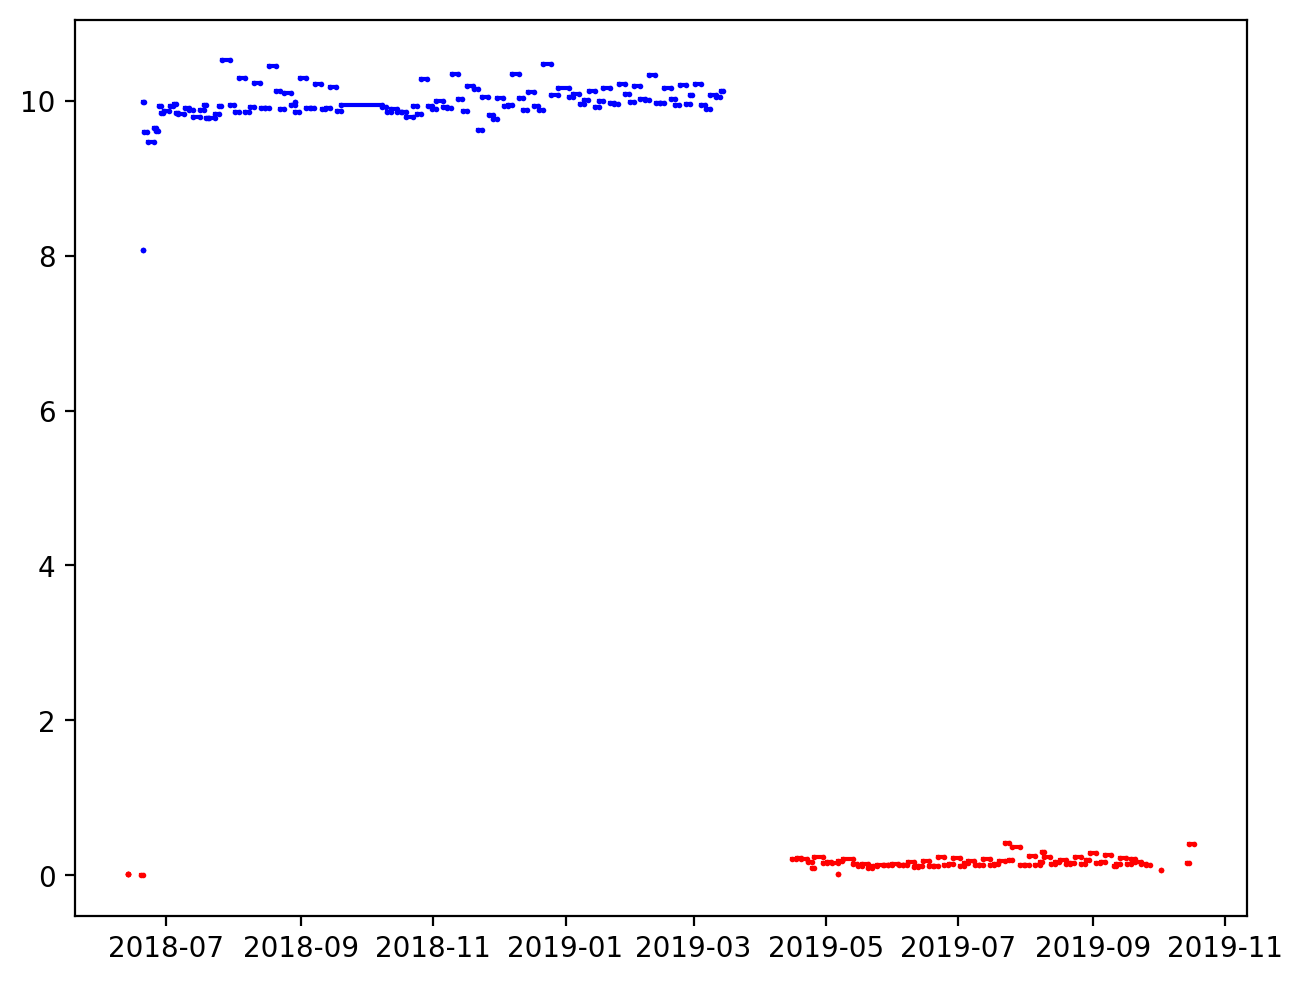

In [11]:
fig, ax = plt.subplots(layout='constrained')
for start, end, avg, clr in zip(starttimes, endtimes, means, clrs):
    ax.plot([start, end], [avg, avg], '.-', color=clr, ms=2)